In [47]:
import os
import random
from io import BytesIO

import imageio.v3 as iio  # Using imageio v3 for modern API
import matplotlib.pyplot as plt
import numpy
import numpy as np
from PIL import Image
from omero.gateway import BlitzGateway
%matplotlib inline


In [48]:
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public', host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


In [49]:
def print_obj(obj, indent=0):
    """
    Helper method to display info about OMERO objects.
    Not all objects will have a "name" or owner field.
    """
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()))

In [50]:
def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_y = image.getSizeY()
    size_x = image.getSizeX()
    z, t, c = round(size_z / 2), 0, 0  # first plane of the image

    s = "t:%s c:%s z:%s y:%s x:%s" % (size_t, size_c, size_z, size_y, size_x)
    print(s)

    if any([size_x > 1024, size_y > 1024]):
        return None

    zct_list = []
    for t in range(1):
        for c in range(size_c):  # all channels
            #for z in range(1):  # get the Z-stack
            zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    print("Downloading image %s" % image.getName())
    all_planes = numpy.stack(list(planes))
    shape = (1, size_c, 1, size_y, size_x)
    return numpy.reshape(all_planes, newshape=shape)

Checking project idr0115-otsuka-nucleoporins/experimentA
Imaging Method: confocal microscopy
Project:2301  Name:"idr0115-otsuka-nucleoporins/experimentA" (owner=demo)
Dataset:16604  Name:"NUP188" (owner=demo)
Image:13966385  Name:"211116-Nup188-ImagingMedium-cell-3-t6.tif" (owner=demo)


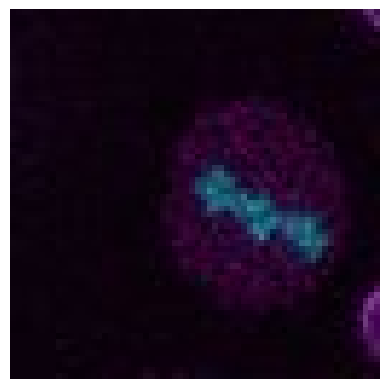

In [51]:
projects = list(conn.getObjects("Project"))
#random_project = conn.getObject('Project', 1304)

# Define the attribute and the value you're looking for
attribute_name = "Imaging Method"
# Define your search terms as a list
search_terms = ["fluorescence", "confocal"]

foundProject = False

while not foundProject:
    random_project = random.choice(projects)
    print(f'Checking project {random_project.getName()}')
    kv_annotations = random_project.listAnnotations()  # or specific namespace if known
    for annotation in kv_annotations:
        if hasattr(annotation, 'getMapValue'):  # check if it's a MapAnnotation
            for key_value_pair in annotation.getMapValue():
                key = key_value_pair.name
                value = key_value_pair.value
                if key == attribute_name:
                    print(f'{key}: {value}')
                    if any(term.lower() in value.lower() for term in search_terms):
                        foundProject = True
                        break

datasets = list(random_project.listChildren())
random_dataset = random.choice(datasets)
#random_dataset = conn.getObject('Dataset', 11862)
images = list(random_dataset.listChildren())
random_image = random.choice(images)
#random_image = conn.getObject('Image', 10503143)

print_obj(random_project)
print_obj(random_dataset)
print_obj(random_image)

raw_thumb = random_image.getThumbnail()
rendered_thumb = Image.open(BytesIO(raw_thumb))

# Display the thumbnail using Matplotlib
plt.imshow(rendered_thumb)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [52]:
data = load_numpy_array(random_image)

t:250 c:2 z:21 y:149 x:167


In [53]:
def generate_crosstalk_data(pure_target_channel: np.ndarray, pure_source_channel: np.ndarray,
                            crosstalk_coefficient: float) -> tuple[np.ndarray, np.ndarray]:
    if not (0.0 <= crosstalk_coefficient <= 1.0):
        print("Warning: Crosstalk coefficient is typically between 0 and 1.")

    if pure_target_channel.shape != pure_source_channel.shape:
        raise ValueError("Pure target and source channel images must have the same shape.")

    # Ensure inputs are float to allow for scaling and addition
    pure_target_channel = pure_target_channel.astype(np.float64)
    pure_source_channel = pure_source_channel.astype(np.float64)

    # Calculate the bleed-through signal
    bleed_through_signal = crosstalk_coefficient * pure_source_channel

    # Generate the mixed target channel image
    mixed_target_channel = pure_target_channel + bleed_through_signal

    # The ground truth crosstalk map is simply the bleed-through signal itself
    ground_truth_crosstalk_map = bleed_through_signal

    return mixed_target_channel, ground_truth_crosstalk_map

In [54]:
def save_images(image: np.ndarray, filename: str):
    """
    Saves a NumPy array as a TIFF image.
    Handles appropriate data type conversion for saving.
    """
    # Imageio can handle float32 directly for TIFF.
    iio.imwrite(filename, image, extension='.tif')
    print(f"Saved {filename}")

Saved crosstalk_training_data\inputs\sample_000__alpha_0.00_input.tif
Saved crosstalk_training_data\labels\sample_000_alpha_0.00_label.tif


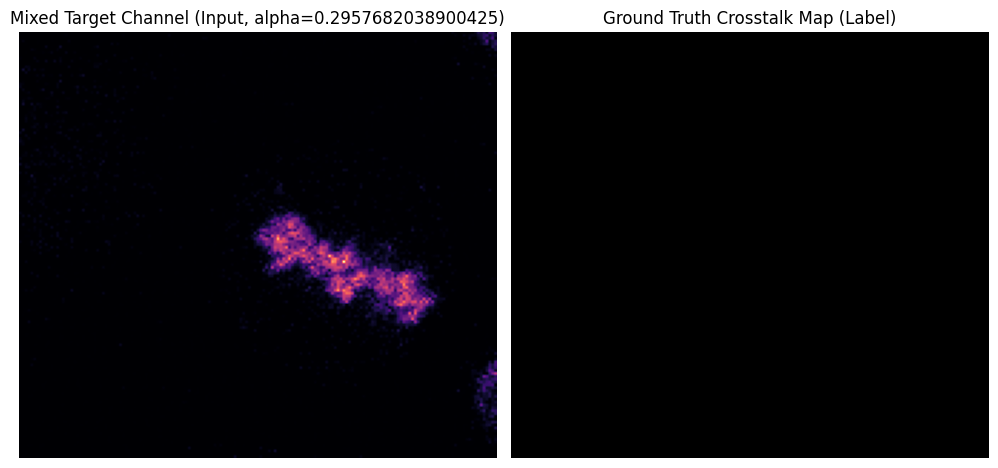

Saved crosstalk_training_data\inputs\sample_001__alpha_0.30_input.tif
Saved crosstalk_training_data\labels\sample_001_alpha_0.30_label.tif


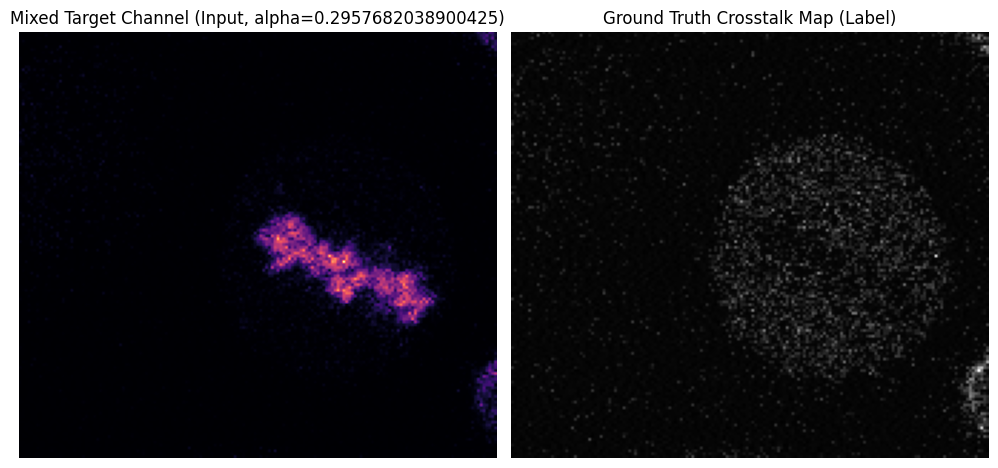


Generated and saved 2 pairs of images to 'crosstalk_training_data/'


In [55]:
if data is not None:
    # Create directories for saving
    output_dir = "crosstalk_training_data"
    input_dir = os.path.join(output_dir, "inputs")
    labels_dir = os.path.join(output_dir, "labels")

    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    source_channel = random.choice(range(np.size(data[0], 0)))
    target_channel = source_channel

    while source_channel == target_channel:
        target_channel = random.choice(range(np.size(data[0], 0)))

    # Define a set of crosstalk coefficients to generate diverse data
    crosstalk_coefficients = [0.0, random.random() * 0.4]  # Include no crosstalk (0.0)

    for i, alpha in enumerate(crosstalk_coefficients):
        mixed_image, true_crosstalk_map = generate_crosstalk_data(
            pure_target_channel=data[0, target_channel, 0],
            pure_source_channel=data[0, source_channel, 0],
            crosstalk_coefficient=alpha
        )

        # Generate unique filenames
        input_filename = os.path.join(input_dir, f"sample_{i:03d}__alpha_{alpha:.2f}_input.tif")
        label_filename = os.path.join(labels_dir, f"sample_{i:03d}_alpha_{alpha:.2f}_label.tif")

        # Save the generated images
        save_images(mixed_image, input_filename)
        save_images(true_crosstalk_map, label_filename)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(mixed_image, cmap='magma')
        axes[0].set_title(f'Mixed Target Channel (Input, alpha={crosstalk_coefficients[-1]})')
        axes[0].axis('off')

        axes[1].imshow(true_crosstalk_map, cmap='gray')
        axes[1].set_title('Ground Truth Crosstalk Map (Label)')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    print(f"\nGenerated and saved {len(crosstalk_coefficients)} pairs of images to '{output_dir}/'")
else:
    print("Image too big!")